## Clustering on Iris Flower Dataset

- Iris flower dataset is supervised data speaking about various Iris flowers with target column `species`. Our objective is to use unsupervised clustering methods to cluster the flowers into specific species with the data available. We can remove the `species` for clustering

### Read and Prepare Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
# Read the data
iris_flower = pd.read_csv('iris.csv')
iris_flower.head(5)

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
# Checking the species type available
iris_flower.species.value_counts()

virginica     50
setosa        50
versicolor    50
Name: species, dtype: int64

Three species type is available in data

In [4]:
# Remove the Species column as it is the target variable. 
# Since, we are using unsupervised clustering, target variable is not required. 
iris_flower.drop('species', axis=1, inplace= True)
iris_flower.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [5]:
# Creating aunique Id number for every flower
iris_flower['ID'] = iris_flower.index + 100
iris_flower.head(5)

,sepal_length,sepal_width,petal_length,petal_width,ID
0,5.1,3.5,1.4,0.2,100
1,4.9,3.0,1.4,0.2,101
2,4.7,3.2,1.3,0.2,102
3,4.6,3.1,1.5,0.2,103
4,5.0,3.6,1.4,0.2,104


- `ID` column cannot be directly assigned using index, because, every time the df is changed, index will be changed. Hence using index+100, hence it will become a constant number

In [6]:
iris_flower.columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'ID'], dtype='object')

### Perform the EDA

In [7]:
# Need to use only 4 features
features = iris_flower.columns[:-1]
list(enumerate(features))

[(0, 'sepal_length'),
 (1, 'sepal_width'),
 (2, 'petal_length'),
 (3, 'petal_width')]

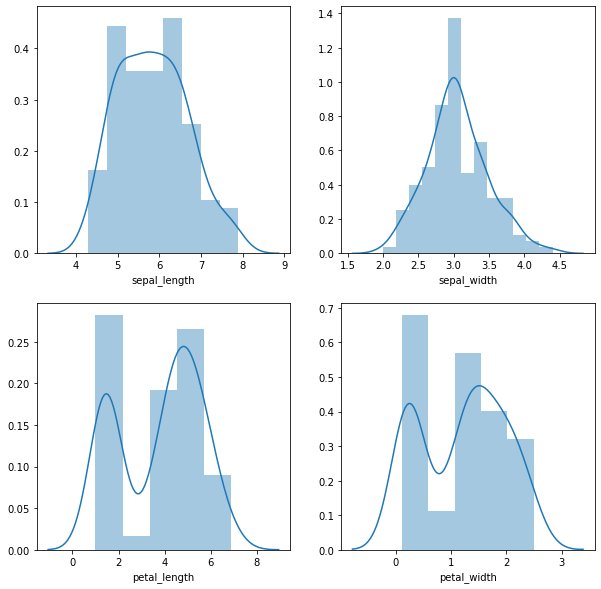

In [8]:
plt.figure(figsize=(10,10))
for i in enumerate(features):
    plt.subplot(2,2,i[0]+1)
    sns.distplot(iris_flower[i[1]])

- From the above diagram, `sepal_length` and `sepal_width` are normally distributed. For `sepal_width` most of the flowers has the value between 2 and 4. Also, `sepal_length` has most of the flowers has value between 5 and 7. So these columns are not informative as expected.
- But `petal_length` and `petal_width` has variation in the data distribution and hence it will be better to use these two columns for profiling

### Outlier Treatment

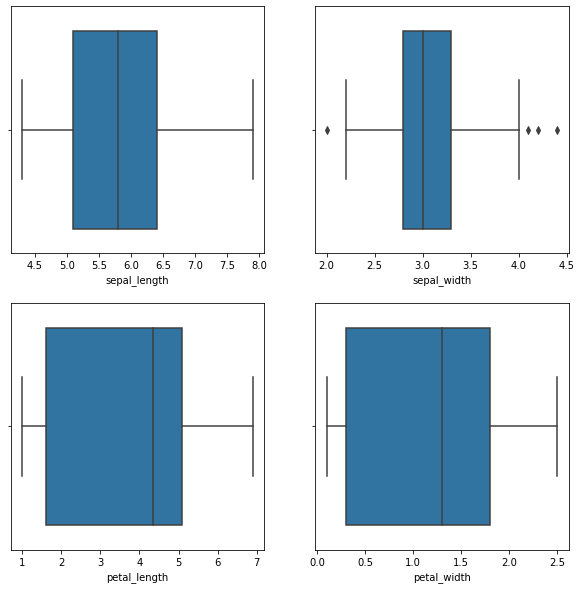

In [9]:
# Use Boxplot to check if there are any outliers in data 
plt.figure(figsize=(10,10))
for i in enumerate(features):
    plt.subplot(2,2,i[0]+1)
    sns.boxplot(iris_flower[i[1]])

- In the above plot, it is clear that column `sepal_width` has some outliers. It is not advisable to remove these outliers as our data set has very less no of rows. So, we can go for capping the data

In [10]:
# Capping - Any value less than 1% become 1 and any value greater than 99 % will become 99 

# Capping
# 1-99: Soft range capping
# 5-95: Mid range capping
# 25 -75: hard range capping

q1 = iris_flower['sepal_width'].quantile(0.01)
q4 = iris_flower['sepal_width'].quantile(0.99)

iris_flower['sepal_width'][iris_flower['sepal_width']<=q1] = q1 
iris_flower['sepal_width'][iris_flower['sepal_width']>=q4] = q4

### Clustering

In [11]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [12]:
hopkins(iris_flower.drop('ID', axis=1))

0.8073531869468257

- Hopkin's Score is More than 80% we can proceed with the clustering

In [13]:
iris = iris_flower.drop('ID', axis=1)

In [14]:
# scaling - Transform the data
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
iris = scaler.fit_transform(iris)

In [15]:
#new df with features
iris = pd.DataFrame(iris)
iris.columns = iris_flower.columns[:-1]
iris.head(5)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.054478,-1.341272,-1.312977
1,-1.143017,-0.125943,-1.341272,-1.312977
2,-1.385353,0.346225,-1.398138,-1.312977
3,-1.506521,0.110141,-1.284407,-1.312977
4,-1.021849,1.290562,-1.341272,-1.312977


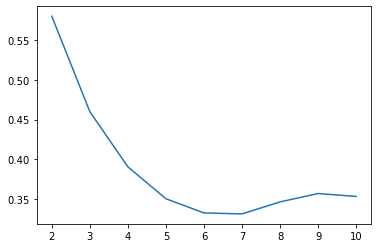

In [16]:
from sklearn.metrics import silhouette_score
ss= [] 
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(iris)
    ss.append([k, silhouette_score(iris, kmeans.labels_)])
    
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])
plt.show()

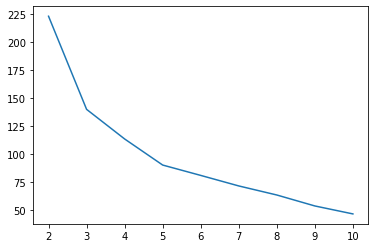

In [17]:
ssd = []
for k in range(2,11):
    kmeans = KMeans(n_clusters = k).fit(iris)
    ssd.append([k, kmeans.inertia_])

plt.plot(pd.DataFrame(ssd)[0], pd.DataFrame(ssd)[1])
plt.show()

In [25]:
# K=3
kmean = KMeans(n_clusters = 3, random_state = 101)
kmean.fit(iris)

KMeans(n_clusters=3, random_state=101)

- Using a random state will help the cluster label to not get changed

In [28]:
cluster = pd.DataFrame(kmean.labels_, columns=['Cluster'])

In [29]:
kmean.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       2, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2], dtype=int32)

In [30]:
iris_df = iris_flower.copy()

In [31]:
iris_df = pd.concat([iris_df, cluster], axis=1)
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,ID,Cluster
0,5.1,3.5,1.4,0.2,100,1
1,4.9,3.0,1.4,0.2,101,1
2,4.7,3.2,1.3,0.2,102,1
3,4.6,3.1,1.5,0.2,103,1
4,5.0,3.6,1.4,0.2,104,1


In [32]:
iris_df.Cluster.value_counts()

2    52
1    50
0    48
Name: Cluster, dtype: int64

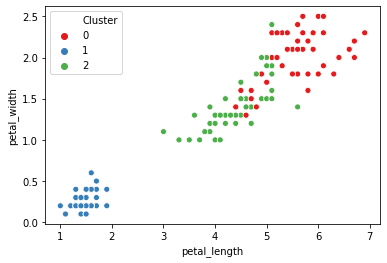

In [35]:
#Plot the clusters 
sns.scatterplot(x = 'petal_length', y = 'petal_width', hue = 'Cluster', data = iris_df, palette = 'Set1')
plt.show()

In [37]:
# Cluster Profiling 
iris_df.drop('ID', axis=1).groupby('Cluster').mean()

,sepal_length,sepal_width,petal_length,petal_width
Cluster,,,,
0,6.777083,3.091667,5.491667,1.958333
1,5.006000,3.412040,1.464000,0.244000
2,5.786538,2.673077,4.365385,1.415385


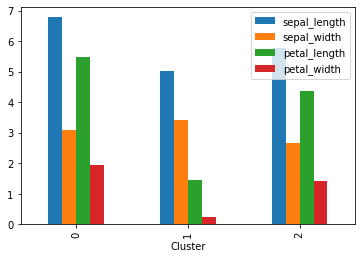

In [39]:
#Plotting the data
iris_df.drop('ID', axis=1).groupby('Cluster').mean().plot(kind='bar')
plt.show()

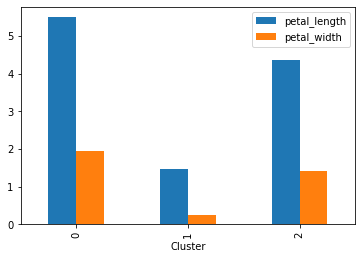

In [40]:
# Removing sepal_length, sepal_width 
iris_df.drop(['ID','sepal_length','sepal_width'], axis=1).groupby('Cluster').mean().plot(kind='bar')
plt.show()

- Cluster 0 is the cluster with high petal_length, petal_width and Cluster 1 is the cluster with low petal_length, petal_width